In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from keras.utils import to_categorical
from keras.models import Model, Sequential
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import h5py
from matplotlib import pyplot as plt
from PIL import Image
from time import time
import logging#程序进展信息
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split#分割数据集
#from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people#下载数据集
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC

Using TensorFlow backend.


In [2]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [3]:
num_classes = len(emotion_labels)


In [4]:
fer_data = h5py.File('./data.h5', 'r', driver='core')

In [5]:
fer_x = np.asarray(fer_data['Training_pixel']).reshape((28709, 48*48))

In [6]:
fer_y = fer_data['Training_label']

In [7]:
X_train = fer_x

In [30]:
X_test_public=np.asarray(fer_data['PublicTest_pixel']).reshape((3589,48*48))

In [31]:
X_test_private=np.asarray(fer_data['PrivateTest_pixel']).reshape((3589,48*48))

In [32]:
num_train = X_train.shape[0]

In [33]:
num_val_public=X_test_public.shape[0]

In [34]:
num_val_private=X_test_private.shape[0]

In [35]:
print('Training: ',X_train.shape)

Training:  (28709, 2304)


In [36]:
print('PublicTest:',X_test_public.shape)

PublicTest: (3589, 2304)


In [37]:
print('PrivateTest:',X_test_private.shape)

PrivateTest: (3589, 2304)


In [38]:
Y_train = fer_data['Training_label']

In [39]:
Y_train = to_categorical(Y_train, num_classes)

In [40]:
Y_test_public=fer_data['PublicTest_label']

In [41]:
Y_test_private=fer_data['PrivateTest_label']

In [42]:
Y_test_public=to_categorical(Y_test_public,num_classes)

In [43]:
Y_test_private=to_categorical(Y_test_private,num_classes)

In [44]:
print('Training:',Y_train.shape)

Training: (28709, 7)


In [45]:
print('PublicTest:',Y_test_public.shape)

PublicTest: (3589, 7)


In [46]:
print('PrivateTest:',Y_test_private.shape)

PrivateTest: (3589, 7)


In [47]:
n_components = 64

In [48]:
pca =PCA(svd_solver='randomized',n_components=n_components,whiten=True).fit(X_train)#降低维度

In [49]:
X_train_pca = pca.transform(X_train)      #得到训练集投影系数

In [50]:
X_val_pca_public = pca.transform(X_test_public) 

In [67]:
X_val_pca_private = pca.transform(X_test_private) 

In [68]:
print(X_train_pca.shape)

(28709, 64)


In [69]:
print(X_val_pca_public.shape)

(3589, 64)


In [70]:
print(X_val_pca_private.shape)

(3589, 64)


In [71]:
eigenfaces = pca.components_.reshape((n_components, 48, 48))

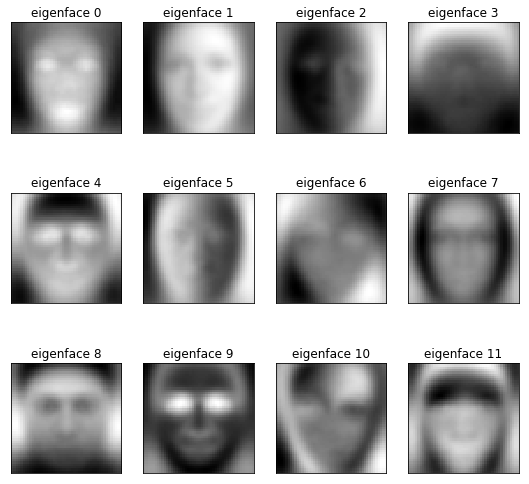

In [72]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
 
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, 48, 48)
plt.show()

In [75]:
y_train_ = np.argmax(Y_train, axis=-1)

In [76]:
y_train_.shape

(28709,)

In [77]:
print("Fitting the classifier to the training set")

Fitting the classifier to the training set


In [78]:
t0 = time()

In [79]:
param_grid = {'C': [1e3],
              'gamma': [0.001], }

In [80]:
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [81]:
clf = clf.fit(X_train_pca[:5000], y_train_[:5000])

/usr/local/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [82]:
print("done in %0.3fs" % (time() - t0))

done in 49.039s


In [83]:
print("Best estimator found by grid search:")

Best estimator found by grid search:


In [84]:
print(clf.best_estimator_)

SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [85]:
print("Predicting people's emotions on the test set")

Predicting people's emotions on the test set


In [86]:
t0 = time()

In [87]:
y_pred_public= clf.predict(X_val_pca_public)

In [88]:
y_pred_private= clf.predict(X_val_pca_private)

In [89]:
print("done in %0.3fs" % (time() - t0))

done in 43.859s


In [90]:
y_val_public = np.argmax(Y_test_public, axis=-1)

In [91]:
y_val_private = np.argmax(Y_test_private, axis=-1)

In [93]:
print(classification_report(y_val_public, y_pred_public))

              precision    recall  f1-score   support

           0       0.22      0.33      0.26       467
           1       0.21      0.14      0.17        56
           2       0.22      0.22      0.22       496
           3       0.54      0.53      0.54       895
           4       0.31      0.26      0.28       653
           5       0.52      0.44      0.48       415
           6       0.35      0.33      0.34       607

   micro avg       0.36      0.36      0.36      3589
   macro avg       0.34      0.32      0.33      3589
weighted avg       0.37      0.36      0.36      3589



In [94]:
print(confusion_matrix(y_val_public, y_pred_public, labels=range(num_classes)))

[[152   6  72  94  66  20  57]
 [ 16   8   8   6  12   1   5]
 [105   6 107  82  77  49  70]
 [113   6  68 477  95  28 108]
 [144   7  99 108 170  31  94]
 [ 43   1  71  32  42 184  42]
 [117   4  68  82  91  44 201]]


In [95]:
print(classification_report(y_val_private, y_pred_private))

              precision    recall  f1-score   support

           0       0.24      0.30      0.27       491
           1       0.23      0.16      0.19        55
           2       0.27      0.27      0.27       528
           3       0.53      0.54      0.53       879
           4       0.28      0.26      0.27       594
           5       0.46      0.39      0.42       416
           6       0.36      0.35      0.36       626

   micro avg       0.37      0.37      0.37      3589
   macro avg       0.34      0.33      0.33      3589
weighted avg       0.37      0.37      0.37      3589



In [96]:
print(confusion_matrix(y_val_private, y_pred_private, labels=range(num_classes)))

[[148   8  62  85  91  27  70]
 [ 10   9   6  16   5   2   7]
 [ 82   8 142  71  92  62  71]
 [103   9  74 474  86  33 100]
 [134   2  80 103 157  29  89]
 [ 42   3  78  40  47 162  44]
 [ 94   0  78 109  88  38 219]]
